# Stock Market Analysis & Prediction With Deep Learning

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import warnings
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Getting The Data


The data that we will be using a year worth of stock data from technology company including 'Apple', 'Google', 'Microsoft', 'Amazon'. We will use `yfinance` library in order to fetch the stock data

In [28]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

end = datetime(2024, 12, 31)
start = end - timedelta(days=365)

stock_data = {}

for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end)

for stock, name in zip(tech_list, company_name):
    stock_data[stock]["company_name"] = name

df = pd.concat(stock_data.values(), axis=0)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Change in the price stock over the year  

## Descriptive Statistics

`.describe` generate descriptive statistics. Provides a quick overview of the central tendency, dispersion, and shape of the dataset's distribution, excluding `NaN` (missing) values. 

In [29]:
stock_data['AAPL'].describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,206.369270,208.063374,204.382101,206.107187,5.719756e+07
std,25.589748,25.661096,25.209018,25.401487,3.087430e+07
min,164.224564,165.617978,163.308889,164.572913,2.323470e+07
25%,183.217476,184.320198,181.446764,182.754880,4.187125e+07
50%,213.522369,216.053871,211.210133,213.213394,4.994790e+07
75%,226.839203,228.738960,224.813984,226.880620,6.295815e+07
max,258.735504,259.814335,257.347047,257.906429,3.186799e+08


## Closing Price

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

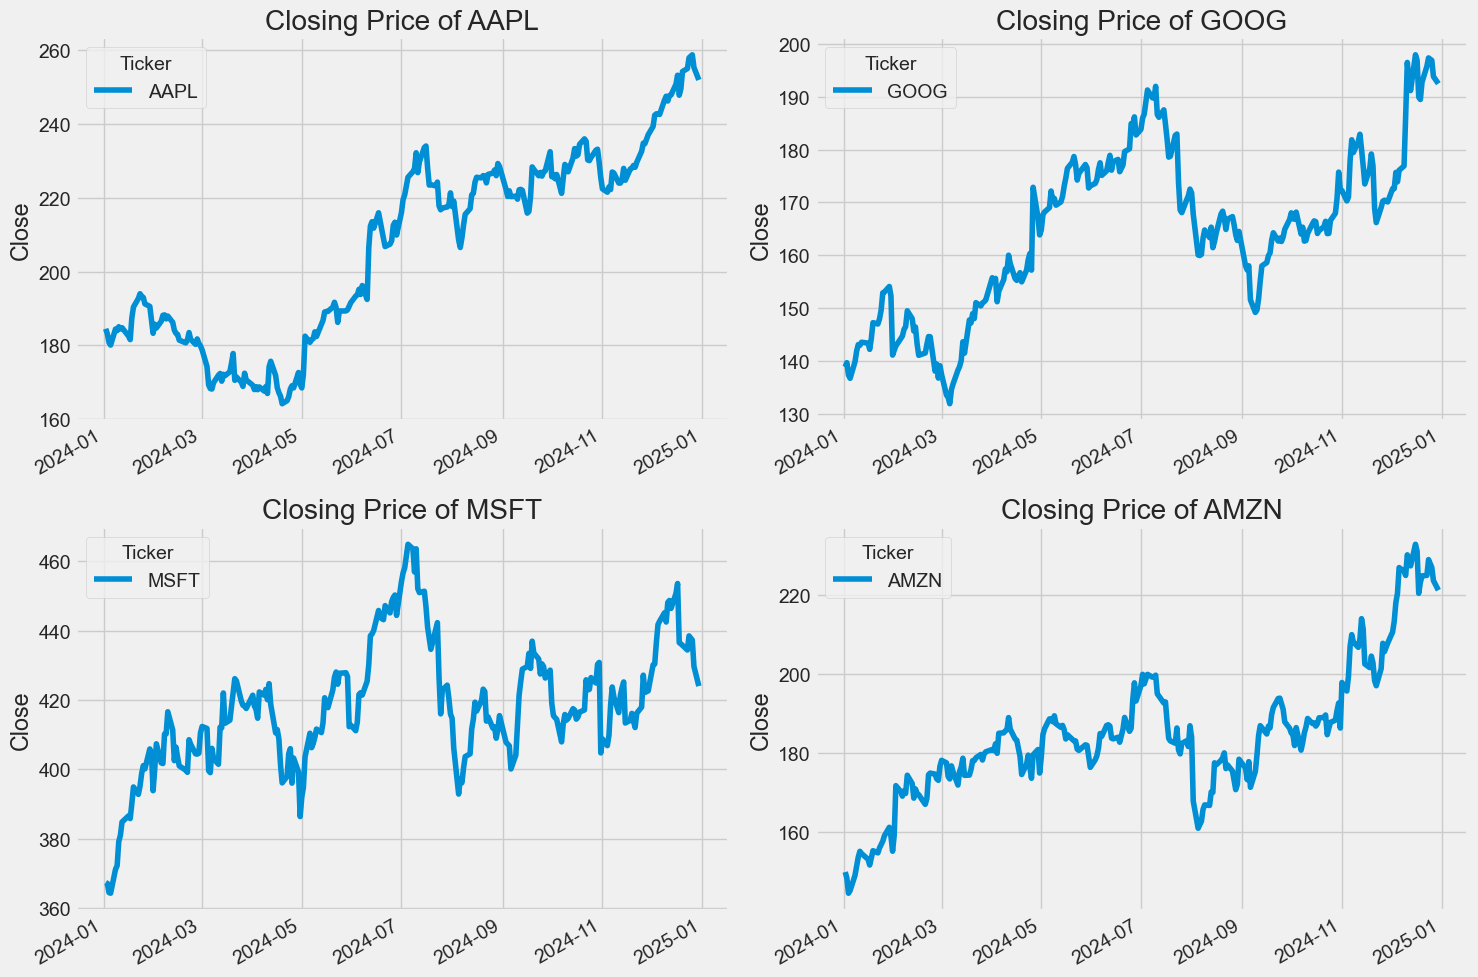

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid

for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker]['Close'].plot(ax=ax)
    ax.set_ylabel('Close')
    ax.set_xlabel(None)
    ax.set_title(f"Closing Price of {ticker}")

plt.tight_layout()
plt.show()


## Volume of sales

total number of shares that are bought or sold (traded) within a specific period of time 

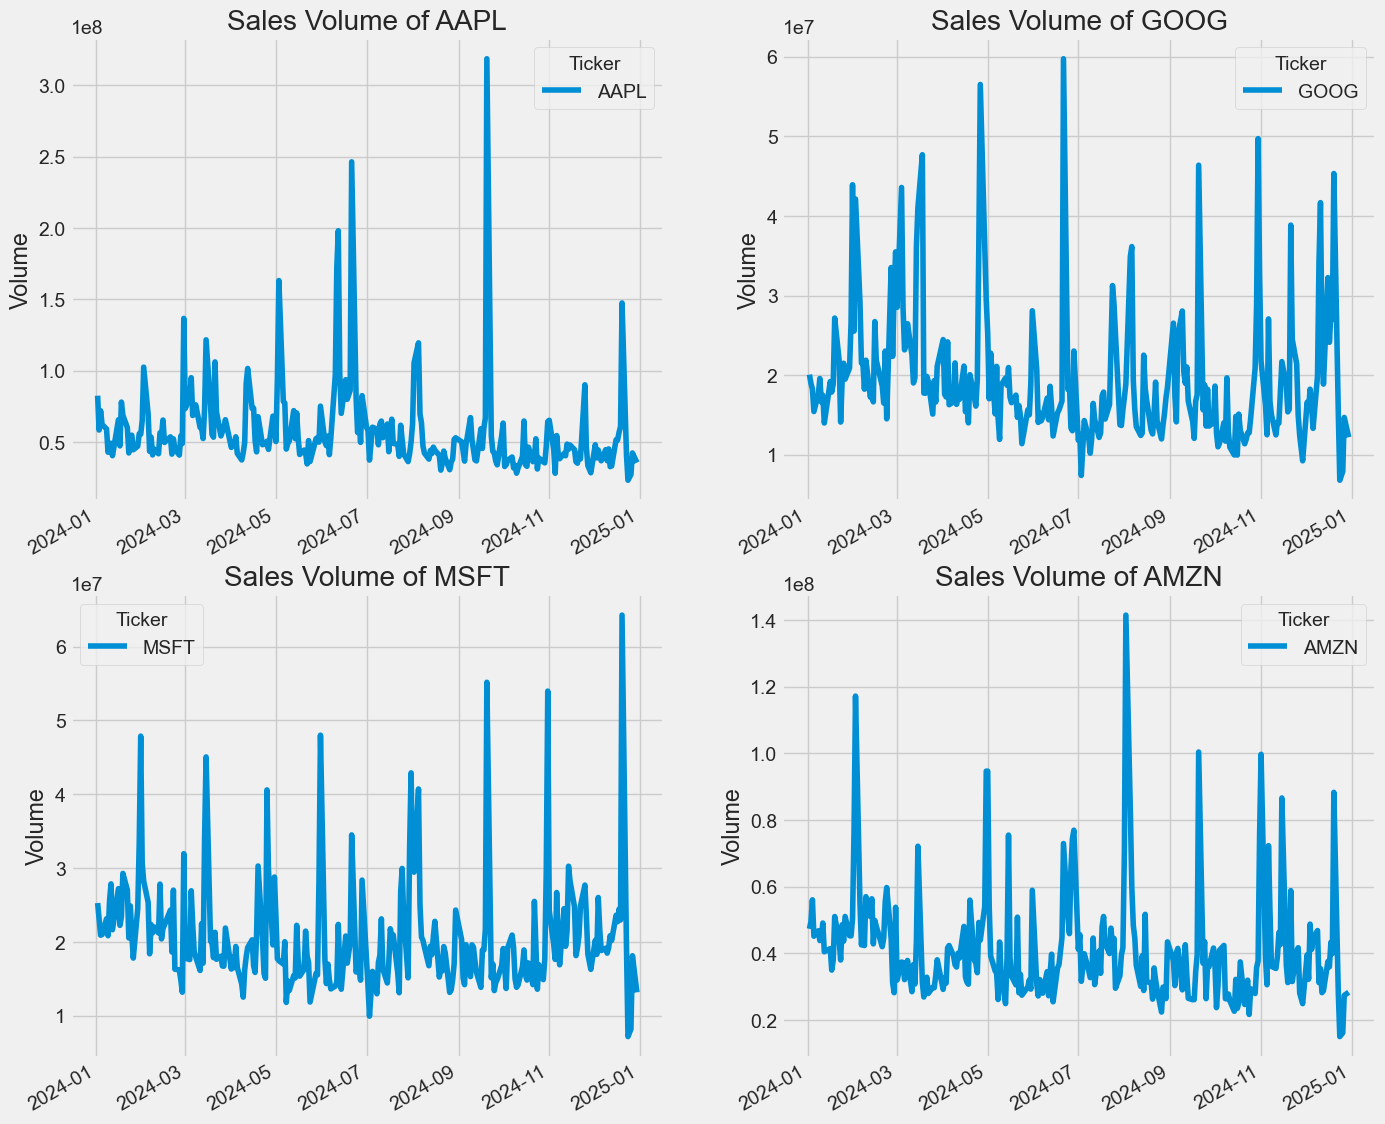

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # 2x2 grid
for ax, ticker in zip(axes.flat, tech_list):  # Flatten grid
    stock_data[ticker]['Volume'].plot(ax=ax)
    ax.set_ylabel('Volume')
    ax.set_xlabel(None)
    ax.set_title(f"Sales Volume of {ticker}")


# Moving Average of Each Stock

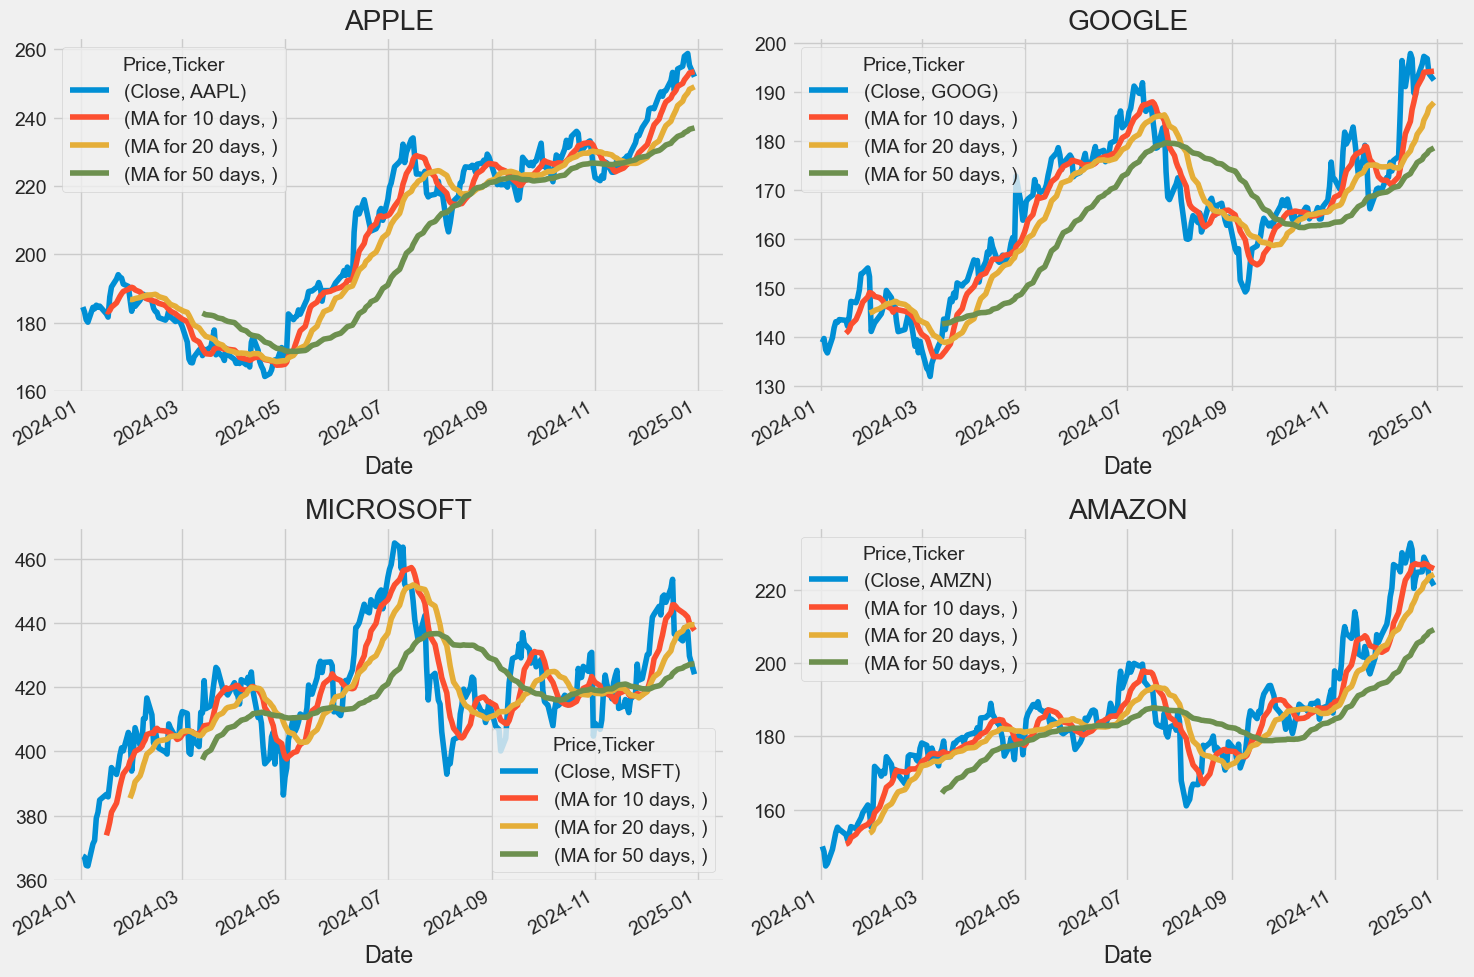

In [32]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for ticker in tech_list:
        column_name = f"MA for {ma} days"
        stock_data[ticker][column_name] = stock_data[ticker]['Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

stock_data['AAPL'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 0])
axes[0, 0].set_title('APPLE')

stock_data['GOOG'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 1])
axes[0, 1].set_title('GOOGLE')

stock_data['MSFT'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1, 0])
axes[1, 0].set_title('MICROSOFT')

stock_data['AMZN'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1, 1])
axes[1, 1].set_title('AMAZON')

fig.tight_layout()
plt.show()


from the graph we can see that using 10 and 20 days moving average we can still capture trends without capturing a lot of noise

# Daily return of stock on Average

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

In [33]:
stock_data['AAPL']['Close'].pct_change()

Ticker,AAPL
Date,
2024-01-02,NaN
2024-01-03,-0.007488
2024-01-04,-0.012700
2024-01-05,-0.004013
2024-01-08,0.024175
...,...
2024-12-23,0.003065
2024-12-24,0.011478
2024-12-26,0.003176


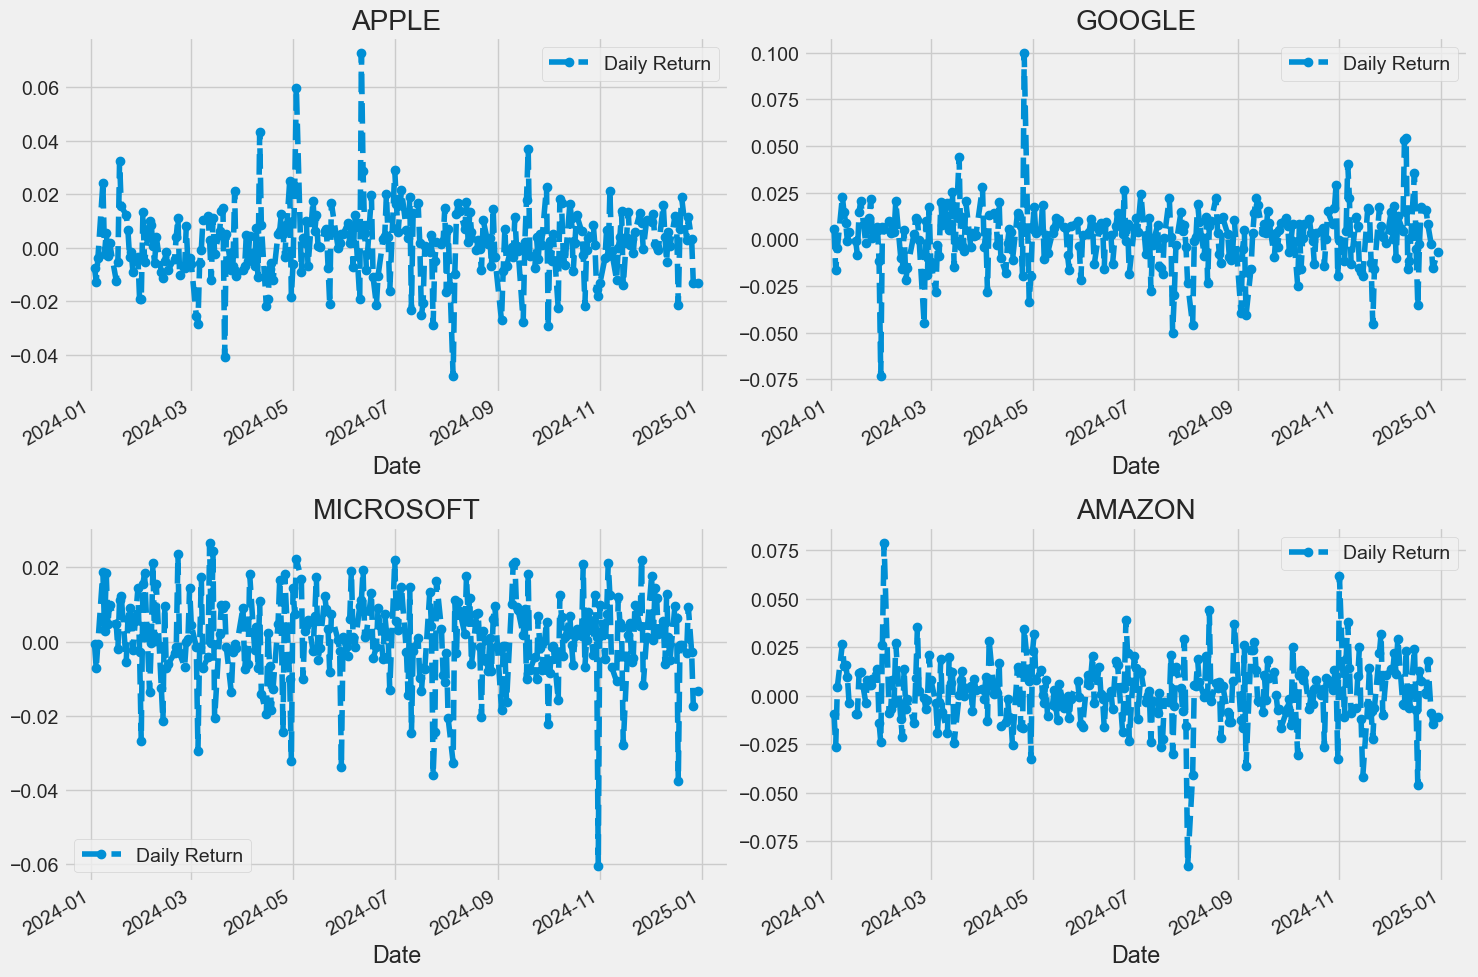

In [34]:
# pct_change to find daily stock value change
for ticker in tech_list:
    stock_data[ticker]['Daily Return'] = stock_data[ticker]['Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)



stock_data['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

stock_data['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

stock_data['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

stock_data['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

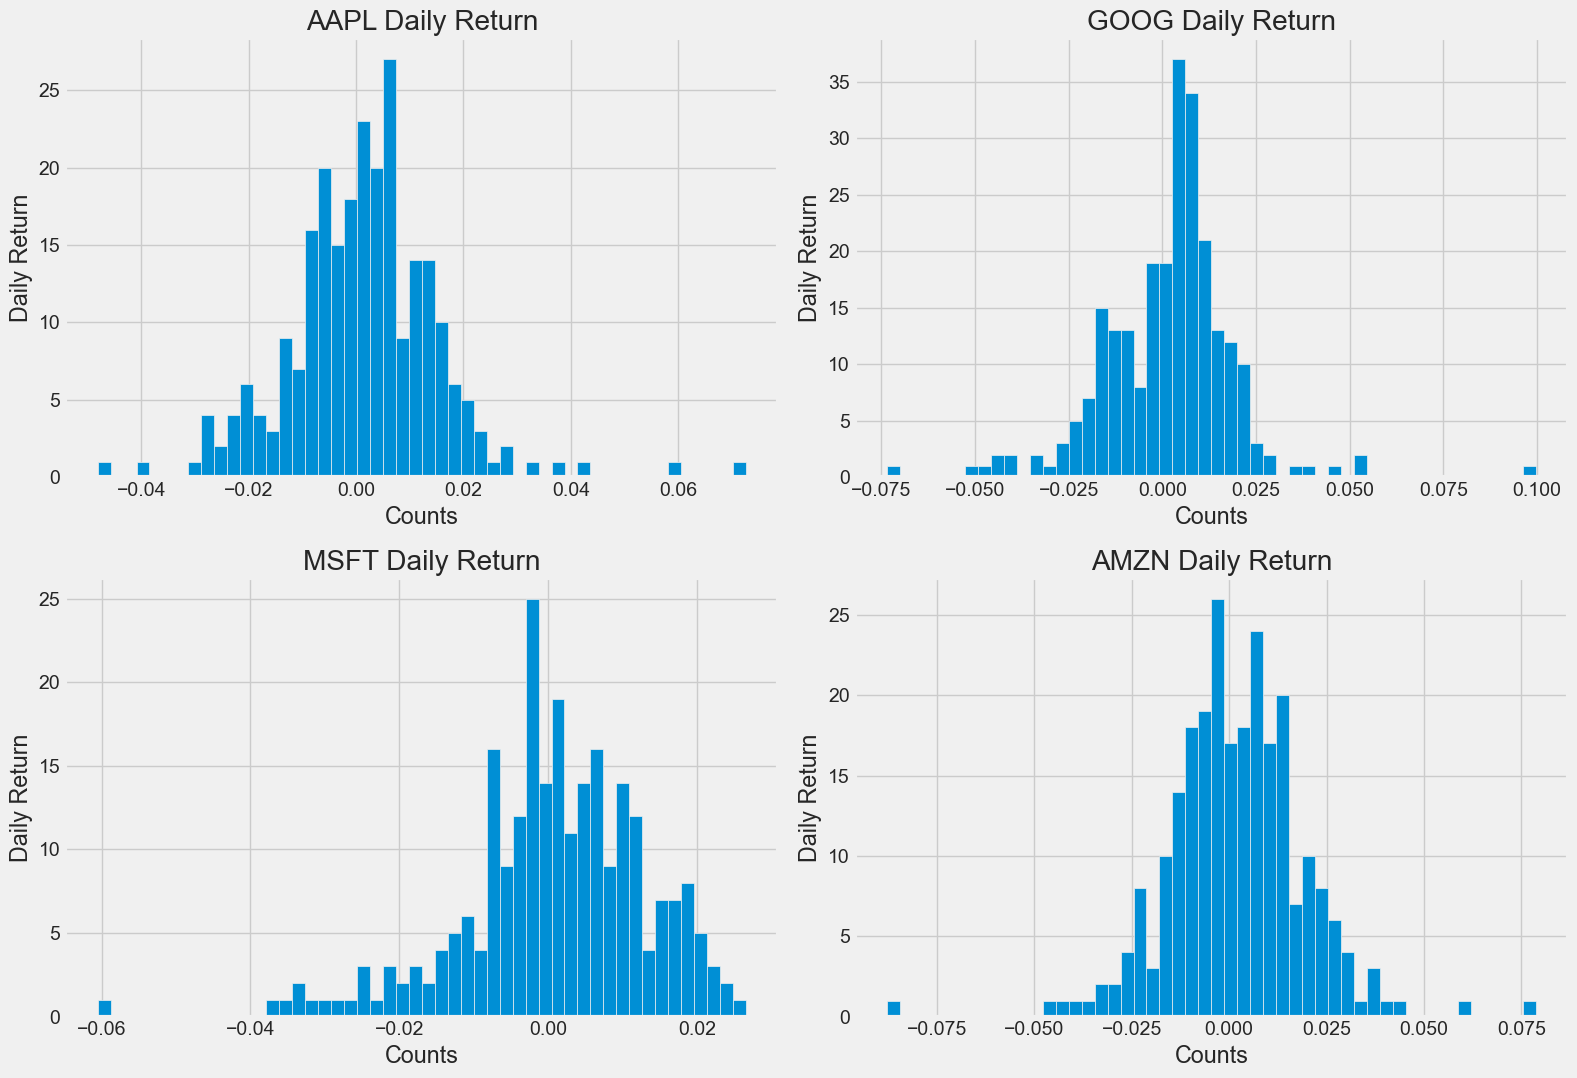

In [35]:
fig, axes = plt.subplots(2,2, figsize=(16,11))
for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker]['Daily Return'].hist(bins=50, ax=ax)
    ax.set_xlabel('Counts')
    ax.set_ylabel('Daily Return')
    ax.set_title(f'{ticker} Daily Return')
    
plt.tight_layout()

# Correlation between different stock closing prices

Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor[1].

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [36]:
closing_df = yf.download(tech_list, start=start, end=end)['Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2024-01-02,NaN,NaN,NaN,NaN
2024-01-03,-0.007488,-0.009738,0.005732,-0.000728
2024-01-04,-0.012700,-0.026268,-0.016529,-0.007178
2024-01-05,-0.004013,0.004634,-0.004709,-0.000516
2024-01-08,0.024175,0.026577,0.022855,0.018871


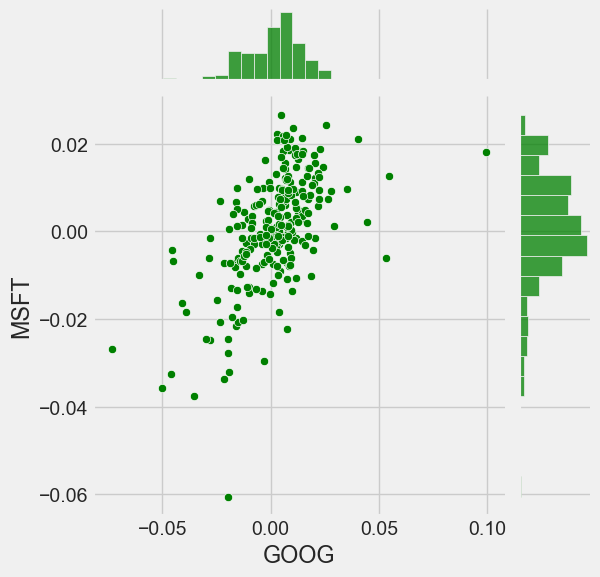

In [37]:
#compare daily returns from of google microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter', color='green')

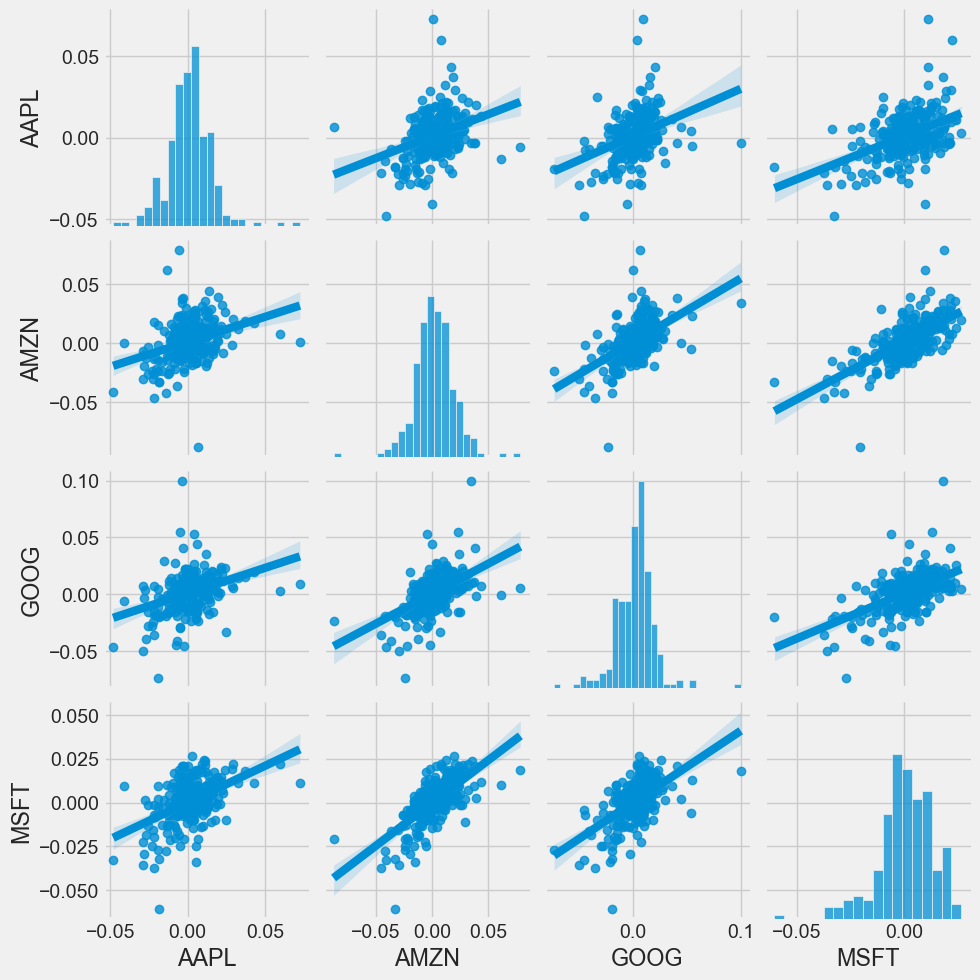

In [38]:
sns.pairplot(data=tech_rets, kind='reg')

The scatter plots are tightly clustered around the regression line, meaning the returns of these stocks are positively correlated.
This suggests that when one stock increases, the others tend to increase as well.


While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this resu

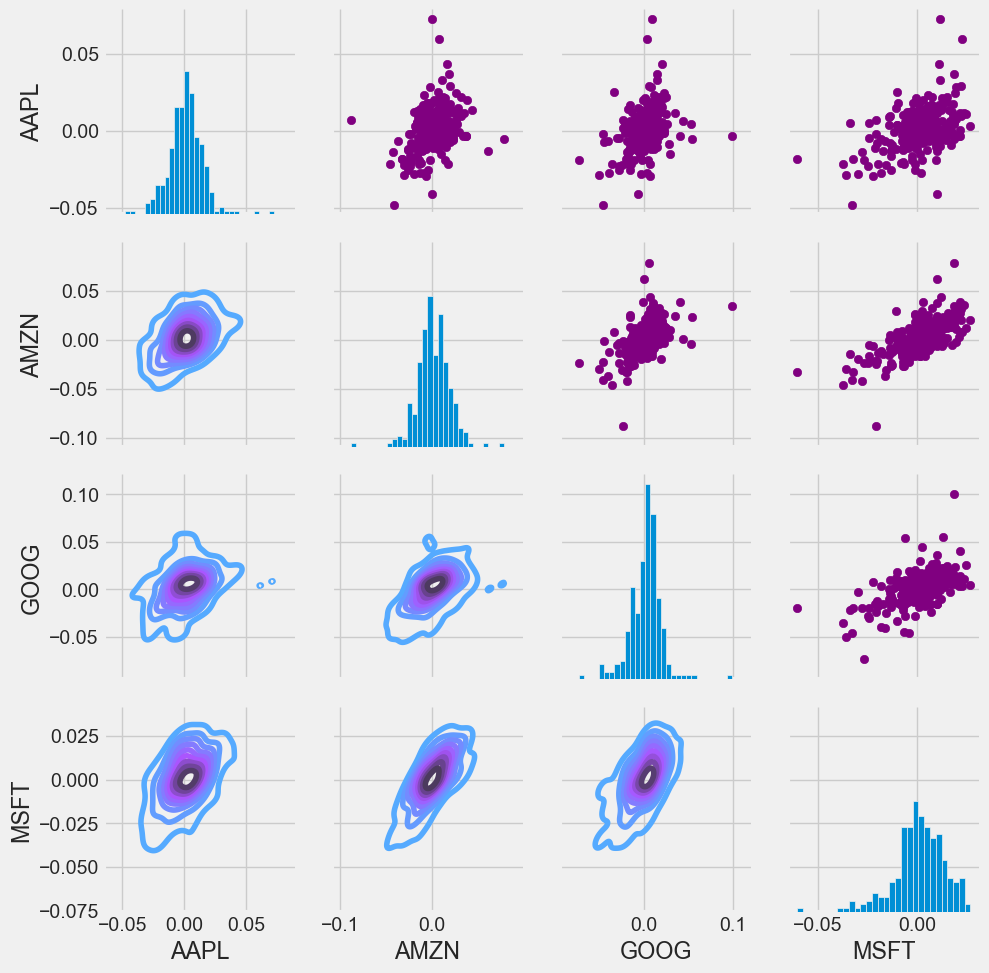

In [ ]:
tech_rets_cleaned = tech_rets.replace([np.inf, -np.inf], np.nan).dropna()
return_fig = sns.PairGrid(tech_rets_cleaned)
return_fig.map_upper(plt.scatter, color="Purple")
return_fig.map_lower(sns.kdeplot, cmap="cool_d")
return_fig.map_diag(plt.hist, bins=30)


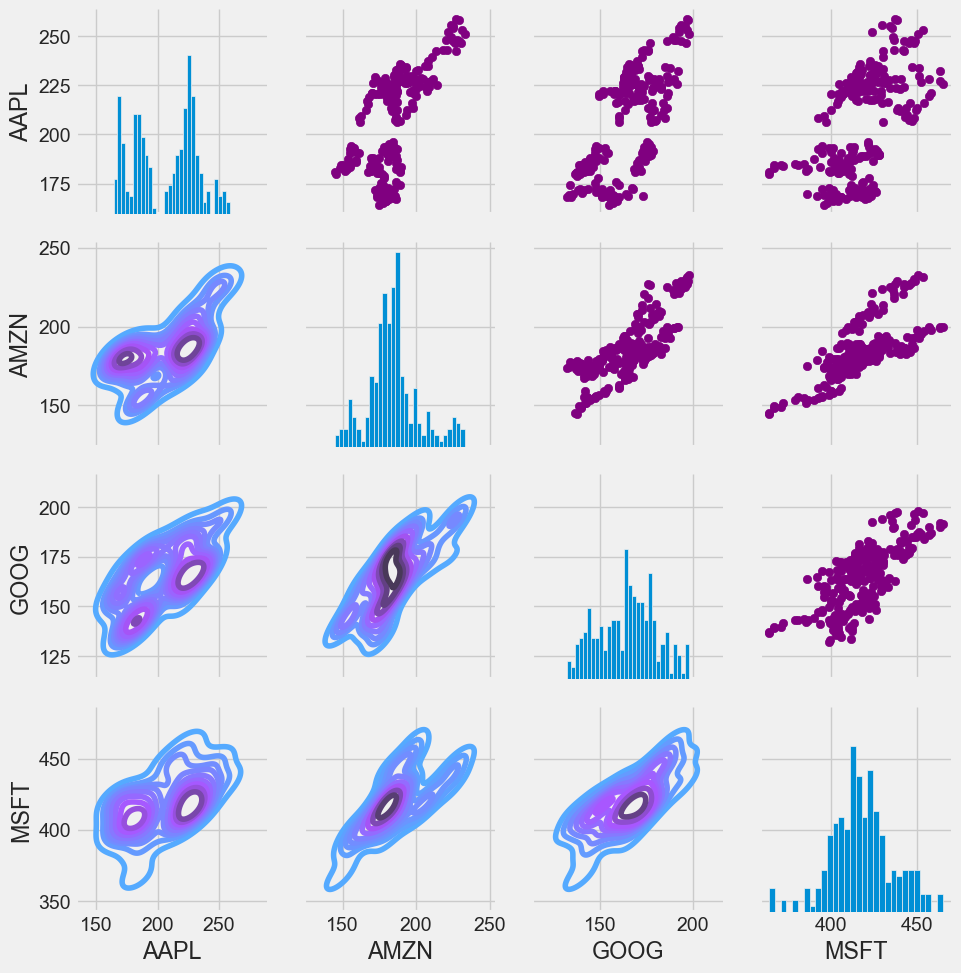

In [40]:
returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

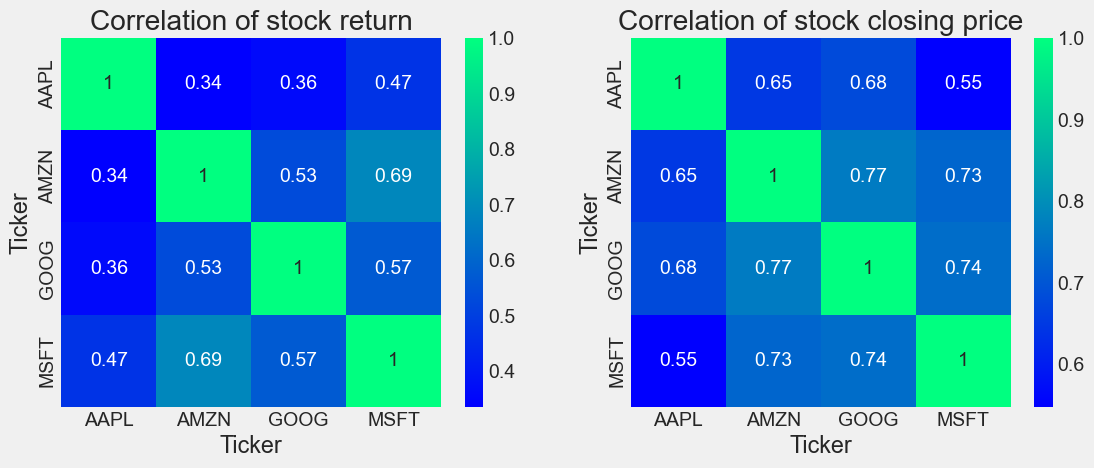

In [41]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='winter')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='winter')
plt.title('Correlation of stock closing price')


# Comparing Each Stock Risk and Return

Comparing the expected return with the standard deviation of the daily returns

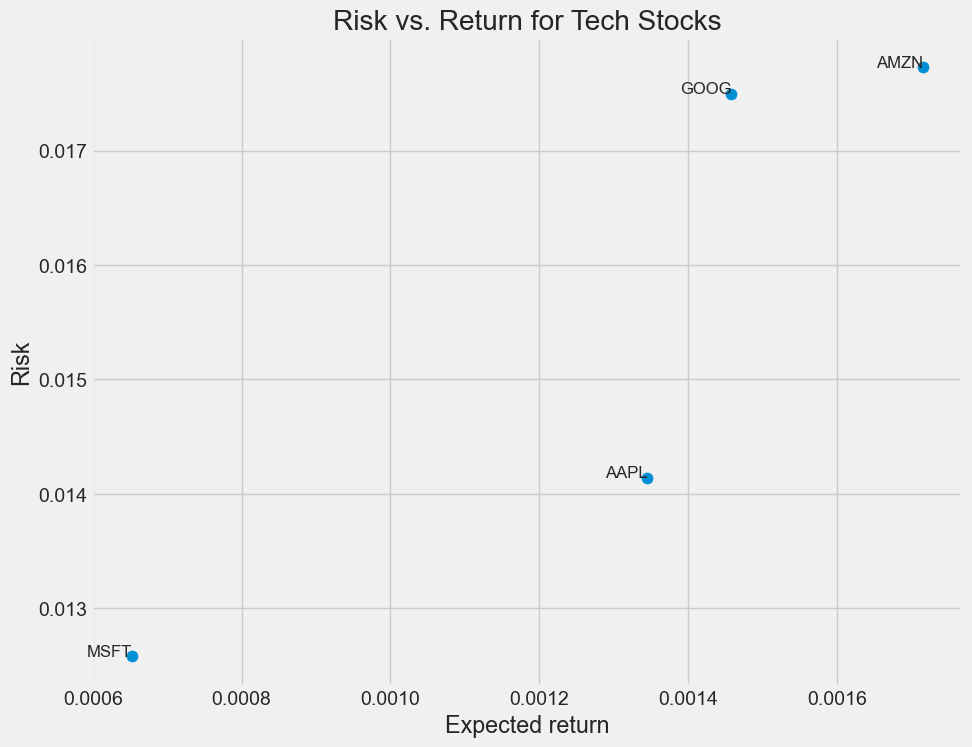

In [42]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for i, name in enumerate(rets.columns):
    plt.text(rets.mean()[i], rets.std()[i], name, fontsize=12, ha='right')

plt.title('Risk vs. Return for Tech Stocks')
plt.grid(True)
plt.show()

# Predict apple stock closing price

In [43]:
df = yf.download('AAPL', start='2015-01-01', end=datetime.now())

[*********************100%***********************]  1 of 1 completed


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2585 entries, 2015-01-02 to 2025-04-11
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2585 non-null   float64
 1   (High, AAPL)    2585 non-null   float64
 2   (Low, AAPL)     2585 non-null   float64
 3   (Open, AAPL)    2585 non-null   float64
 4   (Volume, AAPL)  2585 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 121.2 KB


In [45]:
df['Close']

Ticker,AAPL
Date,
2015-01-02,24.320431
2015-01-05,23.635290
2015-01-06,23.637514
2015-01-07,23.968964
2015-01-08,24.889902
...,...
2025-04-07,181.460007
2025-04-08,172.419998
2025-04-09,198.850006


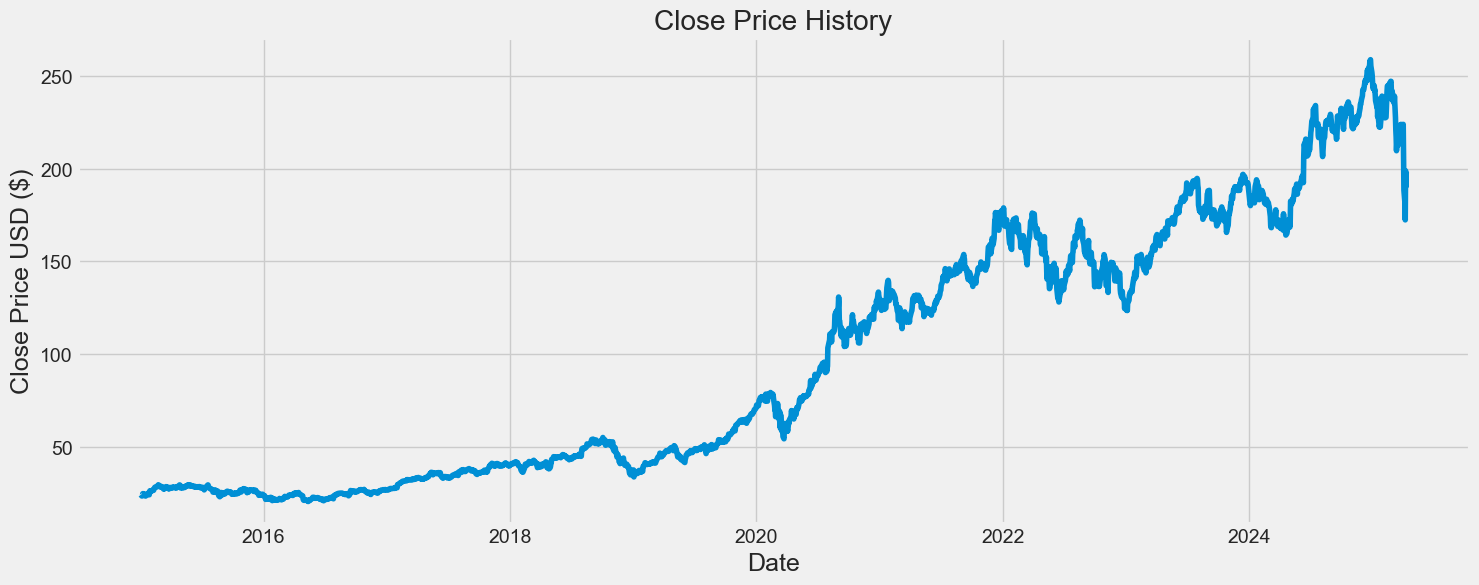

In [46]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [ ]:
data = df['Close']
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len

2456

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01531497],
       [0.01243697],
       [0.01244631],
       ...,
       [0.7484447 ],
       [0.71303357],
       [0.74550423]])

In [49]:
train_data = scaled_data[:training_data_len, :]

In [50]:
train_data[:, :]

array([[0.01531497],
       [0.01243697],
       [0.01244631],
       ...,
       [0.86367559],
       [0.85902311],
       [0.86375943]])

In [51]:
train_data[:, 0]


array([0.01531497, 0.01243697, 0.01244631, ..., 0.86367559, 0.85902311,
       0.86375943])

In [52]:
train_data = scaled_data[:training_data_len, :]
x_train = []
y_train = []


# creating a sliding window 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) # 0 gets only the first column, which means we will get a 1D Array
    y_train.append(train_data[i, 0])

# convert to numpy array since this is necessary before feeding it into deep learning models
x_train, y_train,  = np.array(x_train), np.array(y_train)




# Reshape X_train into 3D Shape (required by LSTM)
#                    (SAMPLE,  TIMESTEPS       , FEATURES)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [53]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train,epochs=20)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0169
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.1099e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.1347e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.9839e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.0636e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.4197e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 2.6600e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.3509e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.0559e-04
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.0036e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.9719e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.7501e-04
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.7301e-04
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.0064e-04
Epoch 15/20
75/75 ━━━━━━━━━━━━

In [54]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 


In [55]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


6.336958025100922

/var/folders/yk/_pmx8td165b2gc_vx9ktfrph0000gn/T/ipykernel_23307/2888502647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


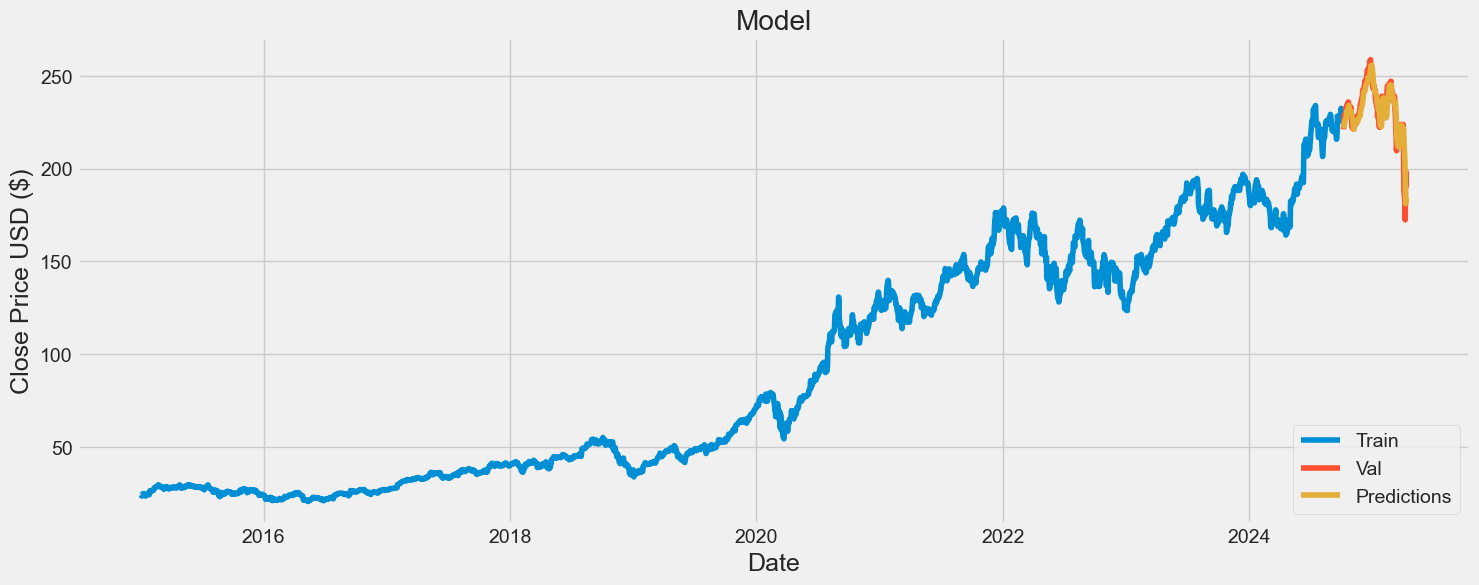

In [58]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(valid[['AAPL', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [59]:
valid

Ticker,AAPL,Predictions
Date,,
2024-10-07,221.203156,224.924164
2024-10-08,225.274200,223.191727
2024-10-09,229.035919,222.930344
2024-10-10,228.537018,224.503326
2024-10-11,227.050293,226.193970
...,...,...
2025-04-07,181.460007,204.418762
2025-04-08,172.419998,192.486664
2025-04-09,198.850006,181.159378
